# 0 IMPORTS

In [1]:
import pandas as pd
import seaborn as sns
import psycopg2 as pg
import pandas.io.sql as psql
import matplotlib.pyplot as plt

from IPython.display      import Image
from IPython.core.display import HTML

import warnings

warnings.filterwarnings( 'ignore' )

## 0.1 Funções auxiliares 

In [2]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    sns.set_palette("Reds") 
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [17]:
jupyter_settings()

## 0.2 Carregamento dos dados

In [3]:
# Credentials
host = 'comunidade-ds-postgres.c50pcakiuwi3.us-east-1.rds.amazonaws.com'
port = 5432
database = 'comunidadedsdb'
username = 'member'
pwd = 'cdspa'

In [4]:
conn = pg.connect(user=username,
                 password=pwd,
                 host=host,
                 port=port,
                 database=database)

In [5]:
query = """
        SELECT
            u.id,
            u.gender,
            u.age,
            u.region_code,
            u.policy_sales_channel,
            i.previously_insured,
            i.annual_premium,
            i.vintage,
            i.response,
            v.driving_license,
            v.vehicle_age,
            v.vehicle_damage
        FROM pa004.users as u 
        LEFT JOIN pa004.insurance as i ON (u.id = i.id)
        LEFT JOIN pa004.vehicle as v ON (u.id = v.id)
        """

In [6]:
df_raw = pd.read_sql(query, conn)
conn.close()

In [7]:
df_raw.head()

,id,gender,age,region_code,policy_sales_channel,previously_insured,annual_premium,vintage,response,driving_license,vehicle_age,vehicle_damage
0,7,Male,23,11.0,152.0,0,23367.0,249,0,1,< 1 Year,Yes
1,13,Female,41,15.0,14.0,1,31409.0,221,0,1,1-2 Year,No
2,18,Female,25,35.0,152.0,1,46622.0,299,0,1,< 1 Year,No
3,31,Female,26,8.0,160.0,0,2630.0,136,0,1,< 1 Year,No
4,39,Male,45,8.0,124.0,0,42297.0,264,0,1,1-2 Year,Yes


# 1 DESCRIÇÃO DOS DADOS

In [8]:
df1 = df_raw.copy()

## 1.1 Dimensão dos dados

In [9]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de colunas: {}'.format(df1.shape[1]))

Número de linhas: 381109
Número de colunas: 12


## 1.2 Tipo dos dados

In [10]:
df1.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
driving_license           int64
vehicle_age              object
vehicle_damage           object
dtype: object

## 1.3 Checagem de valores nulos

In [11]:
df1.isna().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
previously_insured      0
annual_premium          0
vintage                 0
response                0
driving_license         0
vehicle_age             0
vehicle_damage          0
dtype: int64

## 1.4 Análise descritiva

In [12]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64'])

In [13]:
num_attributes.columns

Index(['id', 'age', 'region_code', 'policy_sales_channel',
       'previously_insured', 'annual_premium', 'vintage', 'response',
       'driving_license'],
      dtype='object')

In [14]:
cat_attributes.columns

Index(['gender', 'vehicle_age', 'vehicle_damage'], dtype='object')

### 1.4.1 Atributos númericos

In [15]:
# Central Tendency - mean, mediana, 25%, 75% // dispersion - std, min, max, 
ctd1 = num_attributes.describe()

#dispersion - range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d2 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#join
medidas = pd.concat([ctd1, d1, d2, d3]).T.reset_index()
medidas.columns = ['attributes', 'count','mean', 'std', 'min', '25%', 'median', '75%', 'max', 'range', 'skew', 'kurtosis']


medidas

,attributes,count,mean,std,min,25%,median,75%,max,range,skew,kurtosis
0,id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0,381108.0,-8.071174e-18,-1.200000
1,age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0,65.0,6.725390e-01,-0.565655
2,region_code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0,52.0,-1.152664e-01,-0.867857
3,policy_sales_channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0,162.0,-9.000081e-01,-0.970810
4,previously_insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0,1.0,1.677471e-01,-1.971871
5,annual_premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0,537535.0,1.766087e+00,34.004569
6,vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0,289.0,3.029517e-03,-1.200688
7,response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0,1.0,2.301906e+00,3.298788
8,driving_license,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0,1.0,-2.159518e+01,464.354302


<Figure size 2160x4320 with 0 Axes>

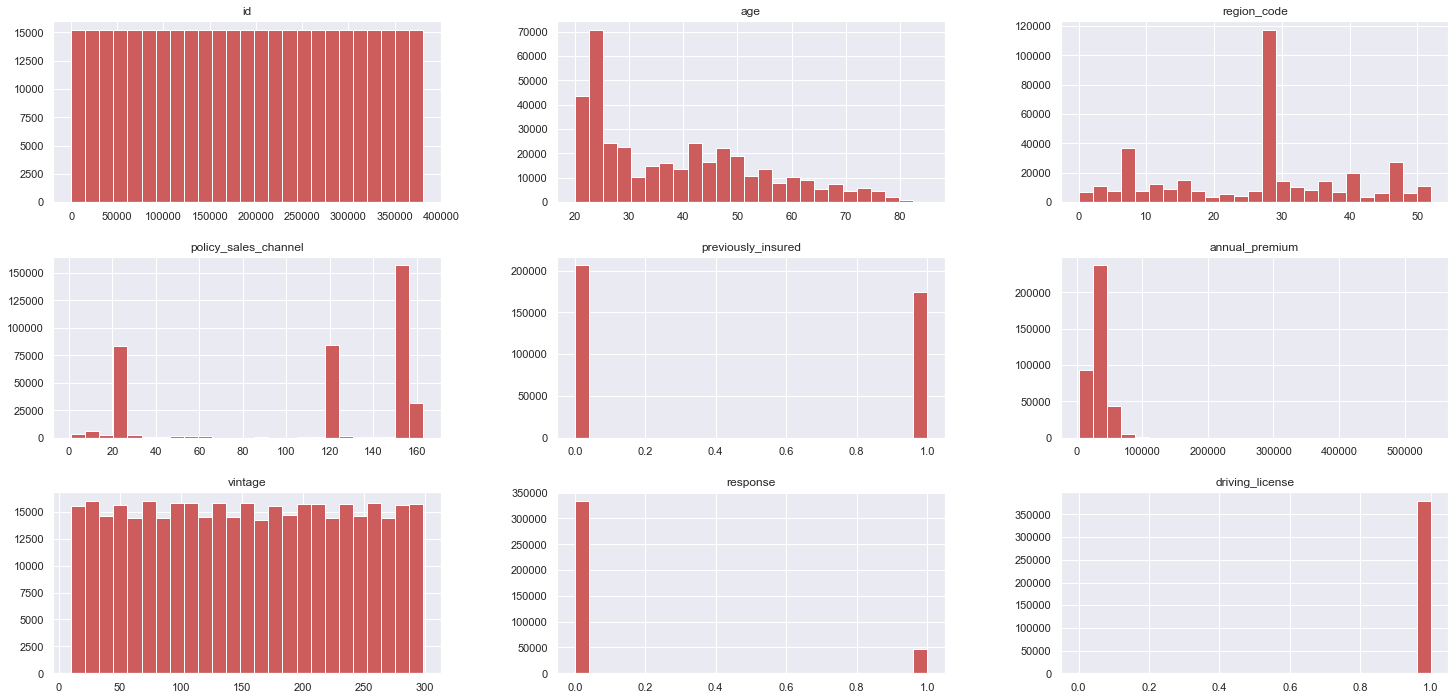

In [18]:
plt.figure(figsize = (30,60))
num_attributes.hist(bins= 25, color= 'indianred');

### 1.7.2 Atributos categóricos

In [19]:
cat_attributes.apply(lambda x: x.unique().shape[0])

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

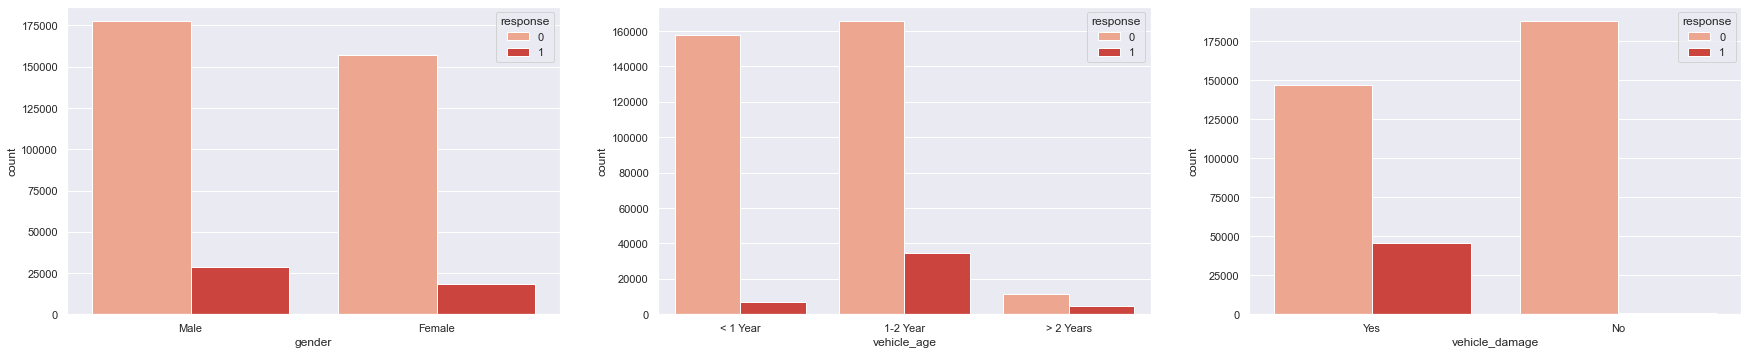

In [28]:
plt.figure(figsize = (30,60))

x = 1
for d in cat_attributes:
    plt.subplot(9, 3, x)
    sns.countplot( x=d, hue='response', data=df1, palette = 'Reds')
    x += 1


# 2 FEATURE ENGINEERING

In [23]:
df2 = df1.copy()

## 2.1 Mapa mental de hipóteses

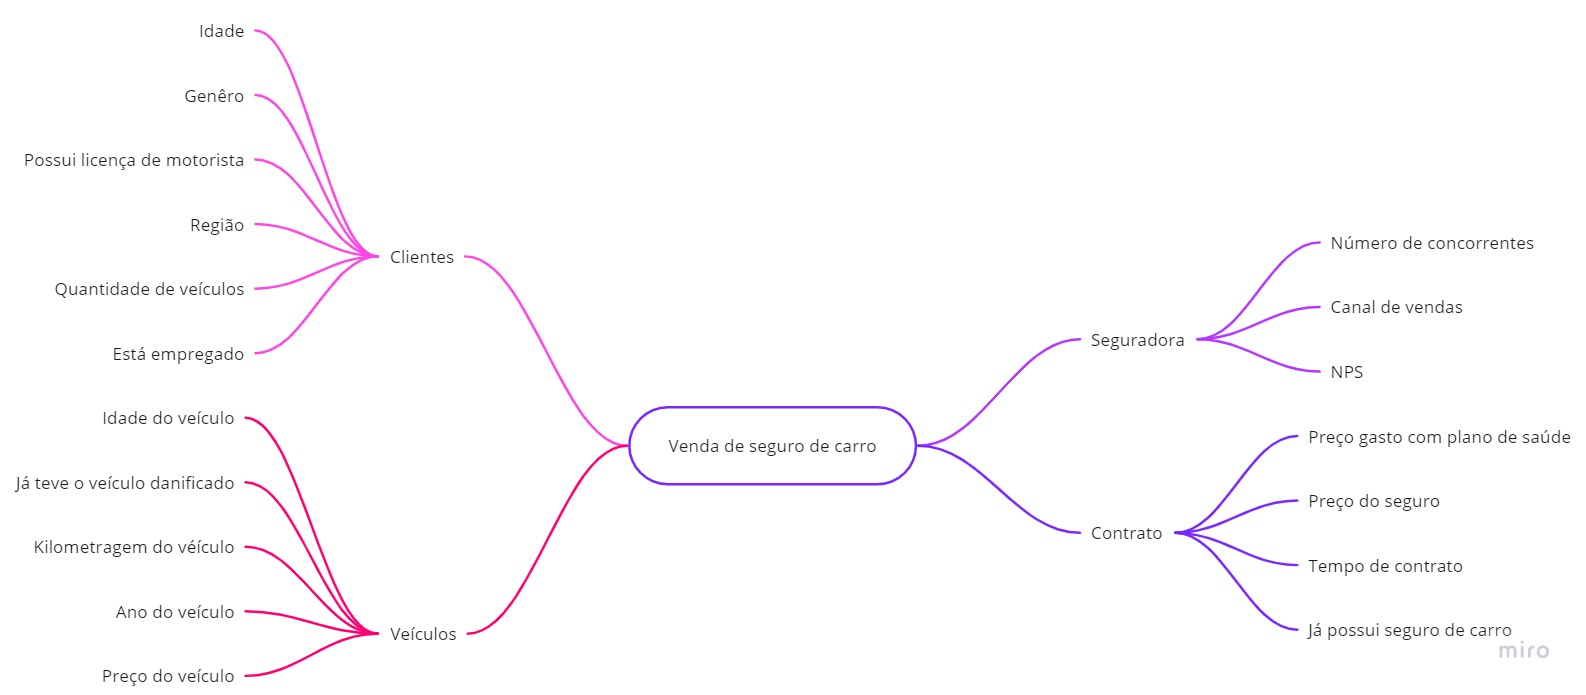

In [25]:
Image("../images/mapa_mental_seguros.jpg")

## 2.2 Criação das hipóteses

### Hipóteses dos Clientes
- Quanto maior a idade, maior a taxa de contratação do seguro
- Clientes do genêro masculino contratam mais o seguro
- Só contrata o seguro de carro quem possuí liceça de motorista
- Clientes que moram em regiões com fluxo de carro maior, contratam mais o seguro
- Regiões com mais Clientes na base contratam mais o seguro
- Clientes com mais veículos contratam mais o seguro
- Clientes empregados contratatam mais o seguro

### Hipóteses dos Veículos
- Quanto menor a faixa de idade do veículo, maior a taxa de contratação do seguro
- Se o veículo já foi danificado, maior é a taxa de contratação
- Quanto maior a kilometragem do veículo, menor é a taxa de contratação
- Quanto mais caro é o veículo, maior é a taxa de contratação do seguro

### Hipóteses da Seguradora
- Quanto maior o número de concorrentes, menor é a taxa de contratação
- Tem canais de vendas que a taxa de contratação é melhor
- Quanto maior o NPS da seguradora, maior é a taxa de contratação


### Hipóteses do Contrato
- Quanto maior a quantia gasto do cliente com o seguro de saúde, maior a taxa de contratação do seguro veicular
- Quanto maior o preço do seguro, menor a taxa de contratação
- Quanto maior o tempo de contrato/vínculo com a seguradora, maior a taxa de contratação
- Se o cliente já possuí seguro com outra seguradora, menor é a taxa de contratação

## 2.3 Criação de variáveis

In [33]:
# vehicle_age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'below_1_year' if x == '< 1 Year' else 'between_1_2_years' if x == '1-2 Year' else 'over_2_years')

# vehicle_damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3 FILTRAGEM DOS DADOS

In [36]:
df3 = df2.copy()